# Make slurm files required to produce SXDS joint VISTA-HSC data product.

In this notebook we will make all the slurm files required to run the whole VISTA-VIDEO HSC-DUD joint photometry pipeline.

We need to find all the patches in the HSC imaging and produce a slurm pipeline file for every patch or group of patches.

This will be a maximum of around 4 tracts * 91 patches per tract = 364 patches

We will also need to set up the data directories including linking relevant reference catalogues and copying the required HSC data products which are already processed.

NOTE: When running the array jobs I am using wildcards to map the index to a given shell script. This is dangerous if you have multiple versions of the slurm scripts as multiple files might have the id.

The processing happens in broadly three stages determined by the inputs and outputs of jobs which dictate parellelisation.

1. processCcd: inputs/outputs = VISTA images/ calexp ccd exposures. One file per VISTA fits image with 16 exposures/stacks.

2. makeCoadd*: inputs/outputs = calexp ccd exposures/coadd patches. One file per patch which runs every night covering a given patch.

3. detect etc: inputs/outputs = coadd patches/source catalogues on every patch. One file per patch.


In [98]:
from astropy.table import Table, Column
import numpy as np
import glob
import os
import json
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'



#We are using a rings skymap
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

#Following taken from dmu1/2_Survey_comparisons.ipynb test choice
coord = SpherePoint(35.429025*degrees,-4.90853*degrees)
config = RingsSkyMapConfig()
#These config options are chose to be the same as HSC:
#https://github.com/lsst/obs_subaru/blob/master/config/hsc/makeSkyMap.py
#and copied for obs_vista
#https://github.com/lsst-uk/obs_vista/blob/master/config/makeSkyMap.py
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0/60 # Overlap between tracts (degrees)
config.pixelScale = 0.168
sm = RingsSkyMap(config)
sm.findTract(coord)

TractInfo(id=8524, ctrCoord=[0.8087076683756161, 0.5811684769959703, -0.09074749834931431])

In [76]:
HSC_LOC = '../../dmu0/dmu0_HSC/data'
#WORK_DIR = '/home/ir-shir1/lsst-ir-fusion/dmu4/dmu4_SXDS'
#WORK_DIR = os. getcwd()
WORK_DIR = '/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu4/dmu4_SXDS'
MAKE_INDIVIDUAL_SLURM=False

In [77]:
!mkdir slurm

mkdir: slurm: File exists


In [78]:
video_ims = Table.read('../../dmu1/data/video_images_overview_20200820.csv')
hsc_ims = Table.read('../../dmu1/data/hsc_images_overview.csv')

In [79]:
tile_to_patch = Table.read('../../dmu1/data/video_tiles_tracts_patches_overview_20200820.csv')

In [80]:
len(video_ims)

137269

## 1 Find all the relevant HSC SXDS patches and corresponding VIDEO images.

The first stage is parallesised by ccd. We will create one job for every date. This should be small enough to fit in a 24hr job.

### 1.1 Get the HSC DUD files in SXDS

In [81]:
sxds_tracts = [8282,8283,8284,8523,8524,8525,8765,8766,8767] #manually got these from HSC DR2 pages
hsc_bands = ['G', 'R', 'I', 'Z', 'Y']
vista_bands = ['Y', 'J', 'H', 'Ks']

In [82]:
hsc_ims['tract'] = [f.split('/')[14] for f in hsc_ims['file']]
hsc_ims['patch'] = [f.split('/')[15] for f in hsc_ims['file']]
hsc_ims['depth'] = [f.split('/')[11] for f in hsc_ims['file']]

In [83]:
in_sxds = hsc_ims['depth'] == 'pdr2_dud' 
in_sxds &= np.isin([int(t) for t in hsc_ims['tract'] ],  sxds_tracts)

In [84]:
np.sum(in_sxds)

1629

In [85]:
hsc_ims['band'] = [f.split('-')[-3] for f in hsc_ims['file']]

In [86]:
hsc_ims[in_sxds][:5]

file,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,size,hash,tract,patch,depth,band
str164,float64,float64,float64,float64,float64,float64,float64,float64,int64,str32,str5,str3,str9,str1
"/home/ir-shir1/rds/rds-iris-ip005/data/public/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-Z/8765/0,0/calexp-HSC-Z-8765-0,0.fits",35.057390881574044,35.05720789563249,34.865503651256965,34.86536233311517,-4.558457292032212,-4.367177057413561,-4.558655394587739,-4.367366830731112,210075840,93e4be0f6ccbf4f282001d491f830060,8765,"0,0",pdr2_dud,Z
"/home/ir-shir1/rds/rds-iris-ip005/data/public/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-Z/8765/2,2/calexp-HSC-Z-8765-2,2.fits",34.68744599488356,34.687340888143005,34.490935877105265,34.49087447536722,-4.19018894495259,-3.9942041159656037,-4.190282501066741,-3.994293285659841,149581440,bb471cb691de84ed694a8179c780c4da,8765,"2,2",pdr2_dud,Z
"/home/ir-shir1/rds/rds-iris-ip005/data/public/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-Z/8765/0,6/calexp-HSC-Z-8765-0,6.fits",35.05632532497644,35.05613835071305,34.864680733040856,34.864536334791445,-3.4433065839296444,-3.2473362428975334,-3.4434561168248923,-3.2474772402754106,64304640,bddc980e7d6fc6007a039863e628abad,8765,"0,6",pdr2_dud,Z
"/home/ir-shir1/rds/rds-iris-ip005/data/public/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-Z/8765/1,3/calexp-HSC-Z-8765-1,3.fits",34.87444848193645,34.87430182037414,34.677990464977505,34.67788748292052,-4.003408172084183,-3.8074234215277722,-4.003542229270651,-3.807550898996197,130622400,28975127e02dcd2d11576f7aa3911d6b,8765,"1,3",pdr2_dud,Z
"/home/ir-shir1/rds/rds-iris-ip005/data/public/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-Z/8765/3,0/calexp-HSC-Z-8765-3,0.fits",34.50041317080672,34.500351147036746,34.30381449491872,34.30379517560638,-4.558891715533787,-4.367593215541012,-4.558942620240526,-4.367641979954217,198616320,7939cb9d2256af91b2e55dbe826edacc,8765,"3,0",pdr2_dud,Z


In [89]:
full_patch_dict = {}
band_dict = { hsc_bands[i]: {} for i in range(len(hsc_bands))}
for tract in sxds_tracts:
    full_patch_dict[tract] = [
        s for s in np.unique(np.array(hsc_ims[in_sxds & (hsc_ims['tract'] == str(tract))]['patch']))
    ]
    for band in hsc_bands:
        band_dict[band][tract] = [
            s for s in np.unique(np.array(hsc_ims[
                in_sxds 
                & (hsc_ims['tract'] == str(tract))
                & (hsc_ims['band'] == band)
            ]['patch']))
        ]

In [92]:
json.dumps(full_patch_dict, separators=(',', ':')) 


'{"8282":["0,8"],"8283":["0,8","1,7","1,8","2,7","2,8","3,7","3,8","4,7","4,8","5,7","5,8","6,7","6,8","7,7","7,8","8,8"],"8284":["8,8"],"8523":["0,1","0,2","0,3","0,4","0,5","0,6","0,7","0,8","1,1","1,2","1,3","1,4","1,5","1,6","1,7","1,8","2,1","2,2","2,3","2,4","2,5","2,6","2,7","2,8","3,1","3,2","3,3","3,4","3,5","3,6","3,7","3,8","4,1","4,2","4,3","4,4","4,5","4,6","4,7","4,8","5,2","5,3","5,4","5,5","5,6","5,7","5,8","6,3","6,4","6,5","6,6","6,7","6,8","7,3","7,4","7,5","7,6","7,7","7,8"],"8524":["0,0","0,1","0,2","0,3","0,4","0,5","0,6","0,7","0,8","1,0","1,1","1,2","1,3","1,4","1,5","1,6","1,7","1,8","2,0","2,1","2,2","2,3","2,4","2,5","2,6","2,7","2,8","3,0","3,1","3,2","3,3","3,4","3,5","3,6","3,7","3,8","4,0","4,1","4,2","4,3","4,4","4,5","4,6","4,7","4,8","5,0","5,1","5,2","5,3","5,4","5,5","5,6","5,7","5,8","6,0","6,1","6,2","6,3","6,4","6,5","6,6","6,7","6,8","7,0","7,1","7,2","7,3","7,4","7,5","7,6","7,7","7,8","8,1","8,2","8,3","8,4","8,5","8,6","8,7","8,8"],"8525":["1,

In [165]:
with open('full_patch_dict.json', 'w') as outfile:
    json.dump(full_patch_dict, outfile)

In [102]:
!mkdir figs

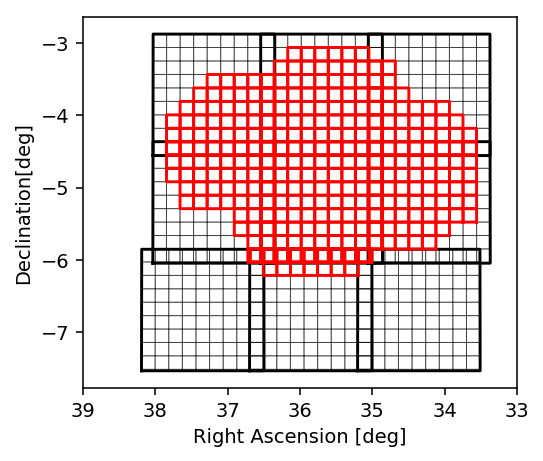

In [131]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
for tract in sxds_tracts:
    vertices = sm.generateTract(tract).getVertexList()
    ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
    dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
    ax.plot(ra, dec, c = 'k')
    for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
        #print(p[0], p[1])
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.5)

#Plot patches on a band
band = 'all'
if band != 'all':
    d = band_dict[band]
else:
    d = full_patch_dict
for tract in d:
    for patch in d[tract]:
        #print(p[0], p[1])
        p = [int(i) for i in patch.split(',')]
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'r')
    
ax.axis('scaled')
ax.set_xlim([39, 33])
ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination[deg]')
fig.savefig('./figs/sxds_HSC-{}_patches.pdf'.format(band), overwrite=True)
fig.savefig('./figs/sxds_HSC-{}_patches.png'.format(band), overwrite=True)

In [127]:
#There are some missing patches in tract 8524 in R that we need to download
HSC_R_missing_patches = []
for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
    if "{},{}".format(p[0], p[1]) not in band_dict['R'][8524]:
        #print("{},{}".format(p[0], p[1]))
        HSC_R_missing_patches.append([int(p[0]), int(p[1])])
HSC_R_missing_patches, len(HSC_R_missing_patches)

([[5, 0],
  [6, 0],
  [7, 0],
  [8, 0],
  [5, 1],
  [6, 1],
  [7, 1],
  [8, 1],
  [5, 2],
  [6, 2],
  [7, 2],
  [8, 2],
  [5, 3],
  [6, 3],
  [7, 3],
  [8, 3],
  [4, 4],
  [5, 4],
  [6, 4],
  [7, 4],
  [8, 4],
  [4, 5],
  [5, 5],
  [6, 5],
  [7, 5],
  [8, 5],
  [4, 6],
  [5, 6],
  [6, 6],
  [7, 6],
  [8, 6],
  [4, 7],
  [5, 7],
  [6, 7],
  [7, 7],
  [8, 7],
  [4, 8],
  [5, 8],
  [6, 8],
  [7, 8],
  [8, 8]],
 41)

In [15]:
#sxds_tracts_patches = {sxds_tracts}
#for t in sxds_tracts_patches:

### 1.2 Find VIDEO images containing those patches

To begin we simply find all tiles which contain the centres of any of those patches

In [132]:
video_ims.add_column(Column(
    data= [t.split('/')[-2] for t in video_ims['file']],
    name='date'))

In [133]:
video_ims.sort('date')

In [134]:
'/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20140924/v20140924_00485.fit'.split('_')[-1].strip('_st_tl.fit')

'00485'

In [135]:
def fileToType(filename):
    filetype = ''
    types = {
        'tile':'_tl.fit',
        'stack':'_st.fit',
    }
    for k,v in types.items():
        #print(k,v)
        if filename.endswith(v):
            filetype = k
  
    return filetype
video_ims['type'] = [fileToType(f) for f in video_ims['file']]

In [136]:
def fileToNumObs(filename):
    "Parse the file name to an obsNum"
    obsNum = filename.split('_')[1].strip('_st_tl_conf.fit')
    return obsNum
video_ims['numObs'] = [fileToNumObs(f) for f in video_ims['file']]

In [137]:
def stackToPatchList(files, file, tile_to_patch):
    """Take a stack file and find the corresponding tile and patch list"""
    tiles_on_date = files[
        (files['date'] == file['date'])
        &(files['type'] == 'tile')
    ]
    numObs = file['numObs']
    #get the largest tile numObs below the stack/exposure numObs for the given date
    try:
        print(file['date'],numObs,tiles_on_date['numObs'])
        tileNumObs = np.max([int(i) if (int(i) <= int(numObs)) else -99 for i in tiles_on_date['numObs']])
        print(tileNumObs)
        tile = '/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/{}/v{}_{}_st_tl.fit'.format(
            file['date'],
            file['date'],
            str(tileNumObs).zfill(5) # turn e.g. int 56 to '00056'
        )
        patches = tile_to_patch[tile_to_patch['file'] == tile]['tract_patch_json'][0]
    except:
        patches = ''
    return patches
#video_ims['tract_patch_json'] = [stackToPatchList(video_ims, i, tile_to_patch) for i in video_ims]
#stackToPatchList(video_ims, video_ims[video_ims['tract_patch_json']==''][0], tile_to_patch)

In [138]:
video_ims[:5]

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,hash,date,type,numObs
str98,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,str32,str8,str5,str5
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00325.fit,36.484021,-4.63957,36.98560193607373,36.986942820117136,36.7931357869821,36.7939859231928,-3.989920268987716,-4.181391042060536,-3.988834504192597,-4.1806173078937405,H,105491520,75436ffeaa57d1946019f75b5815e336,20091103,,00325
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00367.fit,36.481129,-4.63406,36.98912995651607,36.9904674970784,36.79666379317547,36.797510578766826,-3.990063823329973,-4.181534619671177,-3.988974713687807,-4.180757532137754,H,104114880,12892dcb4ba2851a599a378bdad98a7e,20091103,,00367
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00393.fit,36.568479,-4.81736,37.076494313244794,37.07786777023741,36.883984036560555,36.88486460760027,-4.173272093651579,-4.364742639305536,-4.1722175417765595,-4.364000209787858,H,106493760,9416474aa5111d45837d920283a7c1e9,20091103,,00393
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00369.fit,36.568346,-4.64697,37.07627589098966,37.07763727231611,36.88380657765256,36.884677089463565,-4.002906461016393,-4.194377090338556,-4.001841099562346,-4.193623812387667,H,103800960,ca08dee28bd6b37667a5438b7df7fe6c,20091103,,00369
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00386.fit,36.674412,-4.81858,37.182349181000326,37.18374611537194,36.989838489722416,36.99074256239558,-4.174430204796115,-4.365900581559266,-4.17339911824822,-4.365181677523936,H,106246080,02c12907c939625eab7f40e581583c99,20091103,,00386


In [139]:
#TODO make more sophisticated overlap tester. Use patches?
#make list of patches for every tile?
near_sxds = video_ims['type'] == 'stack'
near_sxds &= video_ims['ra'] > 32 #generous bounding box for simplicity 
near_sxds &= video_ims['ra'] < 39
near_sxds &= video_ims['dec'] > -8
near_sxds &= video_ims['dec'] < -1
#Just run Ks for now
#near_sxds &= video_ims['filter'] == 'Ks'

/Users/rs548/GitHub/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Users/rs548/GitHub/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [140]:
np.sum(near_sxds)

5263

In [159]:
tiles_near_sxds = video_ims['type'] == 'tile'
tiles_near_sxds &= video_ims['ra'] > 32 #generous bounding box for simplicity 
tiles_near_sxds &= video_ims['ra'] < 39
tiles_near_sxds &= video_ims['dec'] > -8
tiles_near_sxds &= video_ims['dec'] < -1

In [160]:
np.sum(tiles_near_sxds)

863

In [141]:
tile_to_patch[:1]

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,hash,type,tract_patch_json
str93,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,str32,str4,str631
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20140924/v20140924_00444_st_tl.fit,35.429542,-4.72215,36.12993723683939,36.13433423332165,34.912894878395214,34.91462725348546,-4.072782101046067,-5.559458172880838,-4.07547203760631,-5.562153562881393,Y,148561920,ccef567359a9d3f1cef197b5b5dad958,tile,"{""8766"":[[2,0],[2,1],[2,2],[3,0],[3,1],[3,2],[4,0],[4,1],[4,2],[5,0],[5,1],[5,2],[6,0],[6,1],[6,2],[7,0],[7,1],[7,2],[8,0],[8,1],[8,2]],""8524"":[[2,2],[2,3],[2,4],[2,5],[2,6],[2,7],[2,8],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[3,8],[4,2],[4,3],[4,4],[4,5],[4,6],[4,7],[4,8],[5,2],[5,3],[5,4],[5,5],[5,6],[5,7],[5,8],[6,2],[6,3],[6,4],[6,5],[6,6],[6,7],[6,8],[7,2],[7,3],[7,4],[7,5],[7,6],[7,7],[7,8],[8,2],[8,3],[8,4],[8,5],[8,6],[8,7],[8,8]],""8765"":[[0,0],[0,1],[0,2]],""8523"":[[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8]]}"


In [142]:
video_ims[near_sxds][:5]

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,hash,date,type,numObs
str98,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,str32,str8,str5,str5
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00326_st.fit,36.576012,-4.64,37.08823163355052,37.08995555636475,36.88482927617349,36.8859752930554,-3.987866954738439,-4.192091543332042,-3.9868182149356515,-4.191410879371404,H,86803200,2410d58d84a26f07f1010a1150313193,20091103,stack,00326
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00361_st.fit,36.482612,-4.64011,36.99730036933133,36.99898264493762,36.79056354585063,36.79165308031856,-3.9879327432794103,-4.194323243877787,-3.986773049689245,-4.19354190751726,H,88784640,c33e62145d53d22e4d4a0981b0c9dca3,20091103,stack,00361
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00391_st.fit,36.574512,-4.8233,37.090405452822694,37.09215343959273,36.88401211258498,36.88516715627871,-4.171965219831058,-4.378404636823602,-4.170908971603986,-4.377728217979376,H,90155520,9432149081dbbabdd2e49188b508d40a,20091103,stack,00391
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00377_st.fit,36.666387,-4.64011,37.181911349666635,37.183711783195584,36.97552002531141,36.97672988686314,-3.9882754312027484,-4.194658362408524,-3.987245352372556,-4.194007866262817,H,89078400,0c264294d07d4ef68a6835523da85261,20091103,stack,00377
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00333_st.fit,36.667887,-4.64001,37.180057354163154,37.181794976732,36.97657410259618,36.97773353926015,-3.9878357167901357,-4.192071768125217,-3.9868068960692162,-4.191411222306248,H,86955840,e7496362227fd6e1389172c145151696,20091103,stack,00333


In [143]:
video_ims[near_sxds].write('./data/sxds_tiles.csv')

In [144]:
#For simplicity lets ingest all the images (They are only links and this stage is fast)
#!mkdir data
#!mkdir slurm
#!ingestImages.py data /home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/*/*_st.fit #Stacks
#for date in date_list:
#    #!ingestImages.py data /path/to/vista/{date}/*[0-9].fit #Exposures
#    !ingestImages.py data /path/to/vista/{date}/*_st.fit #Stacks

In [145]:
#date_list = ['20121122', '20171027'] #test dates
date_list = np.unique(video_ims['date'][near_sxds])

In [146]:
#Number of stack files in total tile date list
np.sum(np.isin(video_ims['date'][video_ims['type'] == 'stack'], date_list))

8095

In [147]:
date_list = [date[0:4]+'-'+date[4:6]+'-'+date[6:9] for date in date_list]

In [148]:
date_list

['2009-11-03',
 '2009-11-04',
 '2009-11-05',
 '2009-11-06',
 '2009-11-07',
 '2009-11-08',
 '2009-11-10',
 '2009-11-11',
 '2009-11-12',
 '2009-11-13',
 '2009-11-16',
 '2009-11-17',
 '2009-12-03',
 '2009-12-04',
 '2009-12-05',
 '2009-12-06',
 '2009-12-07',
 '2009-12-08',
 '2009-12-09',
 '2009-12-10',
 '2009-12-11',
 '2009-12-12',
 '2009-12-15',
 '2009-12-16',
 '2009-12-17',
 '2009-12-20',
 '2009-12-21',
 '2009-12-22',
 '2009-12-24',
 '2009-12-29',
 '2010-01-03',
 '2010-01-04',
 '2010-01-07',
 '2010-01-08',
 '2010-01-12',
 '2010-01-16',
 '2010-01-17',
 '2010-01-26',
 '2010-01-28',
 '2010-01-29',
 '2010-01-30',
 '2010-01-31',
 '2010-02-02',
 '2010-07-21',
 '2010-07-24',
 '2010-07-27',
 '2010-07-28',
 '2010-08-04',
 '2010-08-05',
 '2010-08-07',
 '2010-08-08',
 '2010-08-14',
 '2010-08-15',
 '2010-08-16',
 '2010-08-17',
 '2010-08-19',
 '2010-08-24',
 '2010-08-25',
 '2010-08-26',
 '2010-09-09',
 '2010-09-10',
 '2010-09-11',
 '2010-09-13',
 '2010-09-14',
 '2010-09-15',
 '2010-09-19',
 '2010-09-

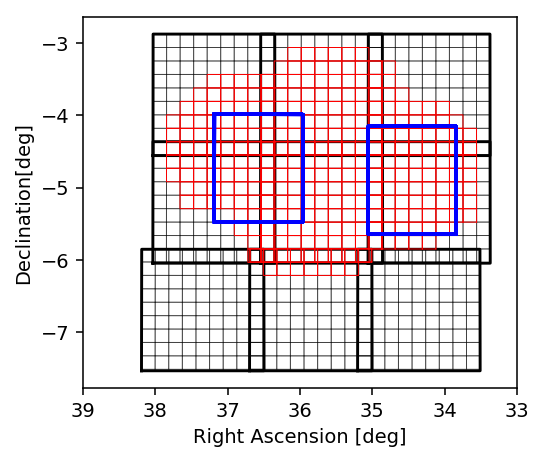

In [164]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
for tract in sxds_tracts:
    vertices = sm.generateTract(tract).getVertexList()
    ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
    dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
    ax.plot(ra, dec, c = 'k')
    for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
        #print(p[0], p[1])
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.5)

#Plot patches on a band
band = 'all'
if band != 'all':
    d = band_dict[band]
else:
    d = full_patch_dict
for tract in d:
    for patch in d[tract]:
        #print(p[0], p[1])
        p = [int(i) for i in patch.split(',')]
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'r', alpha=1.0, linewidth=0.5)
        
v_band ='Z'
for t in video_ims[(video_ims['type'] == 'tile') & (video_ims['filter'] == v_band) & tiles_near_sxds]:

    ra = [t['ra_0_0'], t['ra_x_0'] , t['ra_x_y'] , t['ra_0_y'] , t['ra_0_0'] ]
    dec = [t['dec_0_0'], t['dec_x_0'] , t['dec_x_y'] , t['dec_0_y'] , t['dec_0_0'] ]
    
    ax.plot(ra,dec, c = 'b')
    
ax.axis('scaled')
ax.set_xlim([39, 33])
ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination[deg]')
fig.savefig('./figs/sxds_HSC-{}_patches_VISTA-{}_tiles.pdf'.format(band,v_band), overwrite=True)
fig.savefig('./figs/sxds_HSC-{}_patches_VISTA-{}_tiles.png'.format(band,v_band), overwrite=True)

## 2 Process CCDs

This stage is parallelised accroding to the raw files ingested. We are going to make one job per date

In [33]:
slurm_template= """#!/bin/bash
#!
#! Example SLURM job script for Peta4-Skylake (Skylake CPUs, OPA)
#! Last updated: Mon 13 Nov 12:25:17 GMT 2017
#!

#!#############################################################
#!#### Modify the options in this section as appropriate ######
#!#############################################################

#! sbatch directives begin here ###############################
#! Name of the job:
#SBATCH -J {job_name}
#! Which project should be charged:
#SBATCH -A IRIS-IP005-CPU
#! How many whole nodes should be allocated?
#SBATCH --nodes=1
#! How many (MPI) tasks will there be in total? (<= nodes*32)
#! The skylake/skylake-himem nodes have 32 CPUs (cores) each.
#SBATCH --ntasks=1
#SBATCH --cpus-per-task={cpus_per_task}
#! How much wallclock time will be required?
#SBATCH --time={hours}:00:00
#! What types of email messages do you wish to receive?
#SBATCH --mail-type=FAIL
#! Uncomment this to prevent the job from being requeued (e.g. if
#! interrupted by node failure or system downtime):
##SBATCH --no-requeue

#! For 6GB per CPU, set "-p skylake"; for 12GB per CPU, set "-p skylake-himem": 
#SBATCH -p skylake{himem}

#! sbatch directives end here (put any additional directives above this line)

#! Notes:
#! Charging is determined by core number*walltime.
#! The --ntasks value refers to the number of tasks to be launched by SLURM only. This
#! usually equates to the number of MPI tasks launched. Reduce this from nodes*32 if
#! demanded by memory requirements, or if OMP_NUM_THREADS>1.
#! Each task is allocated 1 core by default, and each core is allocated 5980MB (skylake)
#! and 12030MB (skylake-himem). If this is insufficient, also specify
#! --cpus-per-task and/or --mem (the latter specifies MB per node).

#! Number of nodes and tasks per node allocated by SLURM (do not change):
numnodes=$SLURM_JOB_NUM_NODES
numtasks=$SLURM_NTASKS
mpi_tasks_per_node=$(echo "$SLURM_TASKS_PER_NODE" | sed -e  's/^\([0-9][0-9]*\).*$/\\1/')
#! ############################################################
#! Modify the settings below to specify the application's environment, location 
#! and launch method:

#! Optionally modify the environment seen by the application
#! (note that SLURM reproduces the environment at submission irrespective of ~/.bashrc):
. /etc/profile.d/modules.sh                # Leave this line (enables the module command)
module purge                               # Removes all modules still loaded
module load rhel7/default-peta4            # REQUIRED - loads the basic environment

#! Insert additional module load commands after this line if needed:

#! Full path to application executable: 
application="{sh_name}"

#! Run options for the application:
options=""

#! Work directory (i.e. where the job will run):
workdir="$SLURM_SUBMIT_DIR"  # The value of SLURM_SUBMIT_DIR sets workdir to the directory
                             # in which sbatch is run.

#! Are you using OpenMP (NB this is unrelated to OpenMPI)? If so increase this
#! safe value to no more than 32:
export OMP_NUM_THREADS=1

#! Number of MPI tasks to be started by the application per node and in total (do not change):
np=$[${{numnodes}}*${{mpi_tasks_per_node}}]

#! The following variables define a sensible pinning strategy for Intel MPI tasks -
#! this should be suitable for both pure MPI and hybrid MPI/OpenMP jobs:
export I_MPI_PIN_DOMAIN=omp:compact # Domains are $OMP_NUM_THREADS cores in size
export I_MPI_PIN_ORDER=scatter # Adjacent domains have minimal sharing of caches/sockets
#! Notes:
#! 1. These variables influence Intel MPI only.
#! 2. Domains are non-overlapping sets of cores which map 1-1 to MPI tasks.
#! 3. I_MPI_PIN_PROCESSOR_LIST is ignored if I_MPI_PIN_DOMAIN is set.
#! 4. If MPI tasks perform better when sharing caches/sockets, try I_MPI_PIN_ORDER=compact.


#! Uncomment one choice for CMD below (add mpirun/mpiexec options if necessary):

#! Choose this for a MPI code (possibly using OpenMP) using Intel MPI.
CMD="mpirun -ppn $mpi_tasks_per_node -np $np $application $options"

#! Choose this for a pure shared-memory OpenMP parallel program on a single node:
#! (OMP_NUM_THREADS threads will be created):
#CMD="$application $options"

#! Choose this for a MPI code (possibly using OpenMP) using OpenMPI:
#CMD="mpirun -npernode $mpi_tasks_per_node -np $np $application $options"


###############################################################
### You should not have to change anything below this line ####
###############################################################

cd $workdir
echo -e "Changed directory to `pwd`.\n"

JOBID=$SLURM_JOB_ID

echo -e "JobID: $JOBID\n======"
echo "Time: `date`"
echo "Running on master node: `hostname`"
echo "Current directory: `pwd`"

if [ "$SLURM_JOB_NODELIST" ]; then
        #! Create a machine file:
        export NODEFILE=`generate_pbs_nodefile`
        cat $NODEFILE | uniq > machine.file.$JOBID
        echo -e "\nNodes allocated:\n================"
        echo `cat machine.file.$JOBID | sed -e 's/\..*$//g'`
fi

echo -e "\nnumtasks=$numtasks, numnodes=$numnodes, mpi_tasks_per_node=$mpi_tasks_per_node (OMP_NUM_THREADS=$OMP_NUM_THREADS)"

echo -e "\nExecuting command:\n==================\n$CMD\n"

eval $CMD 

"""

In [34]:
slurm_array_template="""#!/bin/bash
#! This line is a comment
#! Make sure you only have comments and #SBATCH directives between here and the end of the #SBATCH directives, or things will break
#! Name of the job:
#SBATCH -J {job_name}
#! Account name for group, use SL2 for paying queue:
#SBATCH -A IRIS-IP005-CPU
#! Output filename:
#! %A means slurm job ID and %a means array index
#SBATCH --output={jobNameBase}_%A_%a.out
#! Errors filename:
#SBATCH --error={jobNameBase}_%A_%a.err

#! Number of nodes to be allocated for the job (for single core jobs always leave this at 1)
#SBATCH --nodes=1
#! Number of tasks. By default SLURM assumes 1 task per node and 1 CPU per task. (for single core jobs always leave this at 1)
#SBATCH --ntasks=1
#! How many many cores will be allocated per task? (for single core jobs always leave this at 1)
#SBATCH --cpus-per-task={cpus_per_task}
#! Estimated runtime: hh:mm:ss (job is force-stopped after if exceeded):
#SBATCH --time={hours}:00:00
#! Estimated maximum memory needed (job is force-stopped if exceeded):
#! RAM is allocated in ~5980mb blocks, you are charged per block used,
#! and unused fractions of blocks will not be usable by others.
#! coadding VIDEO needs ~ 5 cpus worth of memory SBATCH --mem=5980mb
#! Submit a job array with index values between 0 and 31
#! NOTE: This must be a range, not a single number (i.e. specifying '32' here would only run one job, with index 32)
#SBATCH --array={start}-{stop}

#! This is the partition name.
#SBATCH -p skylake{himem}

#! mail alert at start, end and abortion of execution
#! emails will default to going to your email address
#! you can specify a different email address manually if needed.
##SBATCH --mail-type=ALL

#! Don't put any #SBATCH directives below this line

#! Modify the environment seen by the application. For this example we need the default modules.


#! The variable $SLURM_ARRAY_TASK_ID contains the array index for each job.
#! In this example, each job will be passed its index, so each output file will contain a different value
echo "This is job" $SLURM_ARRAY_TASK_ID

#! Command line that we want to run:
{WORK_DIR}/slurm/{jobNameBase}*_$SLURM_ARRAY_TASK_ID.sh"""

In [35]:
sh_template = """#!/bin/bash
source /rfs/project/rfs-L33A9wsNuJk/shared/lsst_stack/loadLSST.bash
setup lsst_distrib
setup obs_vista
eups admin clearLocks
processCcd.py ../data --rerun processCcdOutputs --id dateObs={dateObs} numObs={numObs} --clobber-config
makeCoaddTempExp.py ../data --rerun coadd --selectId dateObs={dateObs} numObs={numObs} filter={_filter} --id filter={_filter} tract=8282^8283^8284^8523^8524^8525^8765^8766^8767  --clobber-config
"""
#By date:
#processCcd.py ../data --rerun processCcdOutputs --id dateObs={obsDate} --clobber-config

In [36]:
n= 0
for im in video_ims[near_sxds]: #date_list:
    date = im['date']
    dateObs = date[0:4]+'-'+date[4:6]+'-'+date[6:9]
    numObs = im['numObs']
    _filter = 'VISTA-' +im['filter'] #filter is a reserved word in python
    job_name = "processCcd_{}_{}_{}".format(dateObs, numObs, n)
    f_sh = open('./slurm/' + job_name + '.sh', "w+")
    f_sh.write(sh_template.format(dateObs=dateObs, numObs=numObs, _filter=_filter))
    f_sh.close()
    if MAKE_INDIVIDUAL_SLURM:
        f_slurm = open('./slurm/' + job_name + '.slurm', "w+")
        f_slurm.write(slurm_template.format(
            job_name=job_name,
            hours='1',
            jobNameBase=WORK_DIR + '/slurm/' + job_name + '.sh',
            cpus_per_task='1',
            himem=''
        ))
        f_slurm.close()
    n+=1


In [37]:
n

5263

In [38]:
jobNameBase='processCcd'
job_name = jobNameBase + '_array_all_{}-{}'.format( 0,n)
slurm_filename = './slurm/'+job_name+'.slurm'
array_slurm = open(slurm_filename, "w+")
array_slurm.write(slurm_array_template.format(
    job_name=job_name,
    hours='36',
    start=0,
    stop=n,
    WORK_DIR=WORK_DIR,
    jobNameBase=jobNameBase,
    cpus_per_task='1',
    himem=''
))
array_slurm.close()
print(slurm_filename)

./slurm/processCcd_array_all_0-5263.slurm


In [39]:
#We can now submit these with
#qsub ./slurm/processCcd*.slurm

## 3 Run full patch
Make one shell script and slurm script for each patch. During coaddition I also need to specify the input data sets. If I simply give the band the process hangs looping over every calexp. So for each patch I need to find for each band all the calexp files which cover it. I hope this can be done using date only so I can just use the tile patch lists made in dmu1.

### 3.1 Copy HSC folders and make sky map



In [40]:
#HSC preprocessed files must be copied into place (perhaps just the relevant tracts)
#hsc_base = /Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_HSC/data/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-
#hsc_target = data/rerun/coaddPhot/deepCoadd-results/HSC-
#for band in ['G', 'I', 'Z', 'Y']:
#    for tract in sxds_tracts: # [8282,8283,8284,8523,8524,8525,8765,8766,8767] 
#!cp -r "{}{}/{}".format(hsc_base,tract) target
#Sky map must also be created
#!makeSkyMap.py data --rerun processCcdOutputs:coadd --clobber-config

In [41]:
cp_hsc_template = """#!/bin/bash
#Prepare Butler repo for processCcd and runPhotopipe slurm runs
source /rfs/project/rfs-L33A9wsNuJk/shared/lsst_stack/loadLSST.bash
setup lsst_distrib
setup obs_vista
eups admin clearLocks
ingestImages.py data /home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/**/*_st.fit
mkdir -p data/rerun/coaddPhot/deepCoadd-results/HSC-G
mkdir -p data/rerun/coaddPhot/deepCoadd-results/HSC-R
mkdir -p data/rerun/coaddPhot/deepCoadd-results/HSC-I
mkdir -p data/rerun/coaddPhot/deepCoadd-results/HSC-Z
mkdir -p data/rerun/coaddPhot/deepCoadd-results/HSC-Y
mkdir -p data/rerun/processCcdOutputs/coadd
makeSkyMap.py data --rerun processCcdOutputs:coadd --clobber-config
"""

In [42]:
HSC='/home/ir-shir1/rds/rds-iris-ip005/data/public/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-'
TARGET='data/rerun/coaddPhot/deepCoadd-results/HSC-'
job_name = "setup_butler_repo"
f_sh = open('./' + job_name + '.sh', "w+")
f_sh.write(cp_hsc_template)
for band, tract in itertools.product(hsc_bands,sxds_tracts):
    f_sh.write(
        'cp -r {}/{} {} \n'.format(HSC+band, tract, TARGET+band )
    )
f_sh.close()


### 3.2 Make files for coadding

Actually I think I can include the tempo exp stage at the per file stage. So there are two stages a tasks per file and tasks per patch stage.

### 3.3 Make shell files and array job for every patch

This has been hanging at the coadd stage I am experimenting with giving it all the visits on a given patch using bash to get them following the tile based stage

In [43]:
patch_sh_template = """#!/bin/bash
source /rfs/project/rfs-L33A9wsNuJk/shared/lsst_stack/loadLSST.bash
setup lsst_distrib
setup obs_vista
eups admin clearLocks
#coadds must be run on every file or they hang due to memory limits
#makeCoaddTempExp.py ../data --rerun coadd --selectId filter=VISTA-Y --id filter=VISTA-Y tract={tract} patch={patch} 
#makeCoaddTempExp.py ../data --rerun coadd --selectId filter=VISTA-Ks --id filter=VISTA-J tract={tract} patch={patch} 
#makeCoaddTempExp.py ../data --rerun coadd --selectId filter=VISTA-Y --id filter=VISTA-H tract={tract} patch={patch} 
#makeCoaddTempExp.py ../data --rerun coadd --selectId filter=VISTA-Ks --id filter=VISTA-Ks tract={tract} patch={patch} 

for f in ../data/rerun/coadd/deepCoadd/VISTA-Z/{tract}/{patch}/*; do export Z_VISITS=$Z_VISITS^${{f:${{#f}}-23:6}}; done
export Z_VISITS=${{Z_VISITS//-}}
export Z_VISITS=${{Z_VISITS//^/' --selectId filter=VISTA-Z visit='}}
assembleCoadd.py ../data --rerun coadd $Z_VISITS --id filter=VISTA-Z tract={tract} patch={patch}

for f in ../data/rerun/coadd/deepCoadd/VISTA-Y/{tract}/{patch}/*; do export Y_VISITS=$Y_VISITS^${{f:${{#f}}-23:6}}; done
export Y_VISITS=${{Y_VISITS//-}}
export Y_VISITS=${{Y_VISITS//^/' --selectId filter=VISTA-Y visit='}}
assembleCoadd.py ../data --rerun coadd $Y_VISITS --id filter=VISTA-Y tract={tract} patch={patch}

for f in ../data/rerun/coadd/deepCoadd/VISTA-J/{tract}/{patch}/*; do export J_VISITS=$J_VISITS^${{f:${{#f}}-23:6}}; done
export J_VISITS=${{J_VISITS//-}}
export J_VISITS=${{J_VISITS//^/' --selectId filter=VISTA-J visit='}}
assembleCoadd.py ../data --rerun coadd $J_VISITS --id filter=VISTA-J tract={tract} patch={patch}

for f in ../data/rerun/coadd/deepCoadd/VISTA-H/{tract}/{patch}/*; do export H_VISITS=$H_VISITS^${{f:${{#f}}-23:6}}; done
export H_VISITS=${{H_VISITS//-}}
export H_VISITS=${{H_VISITS//^/' --selectId filter=VISTA-H visit='}}
assembleCoadd.py ../data --rerun coadd $H_VISITS --id filter=VISTA-H tract={tract} patch={patch}

for f in ../data/rerun/coadd/deepCoadd/VISTA-Ks/{tract}/{patch}/*; do export KS_VISITS=$KS_VISITS^${{f:${{#f}}-23:6}}; done
export KS_VISITS=${{KS_VISITS//-}}
export KS_VISITS=${{KS_VISITS//^/' --selectId filter=VISTA-Ks visit='}}
assembleCoadd.py ../data --rerun coadd $KS_VISITS --id filter=VISTA-Ks tract={tract} patch={patch}

detectCoaddSources.py ../data --rerun coadd:coaddPhot --id filter=VISTA-Z tract={tract} patch={patch}
detectCoaddSources.py ../data --rerun coadd:coaddPhot --id filter=VISTA-Y tract={tract} patch={patch}
detectCoaddSources.py ../data --rerun coadd:coaddPhot --id filter=VISTA-J tract={tract} patch={patch}
detectCoaddSources.py ../data --rerun coadd:coaddPhot --id filter=VISTA-H tract={tract} patch={patch}
detectCoaddSources.py ../data --rerun coadd:coaddPhot --id filter=VISTA-Ks tract={tract} patch={patch}

#HSC files must be copied - Which bands to merge detections from?
#mergeCoaddDetections.py ../data --rerun coaddPhot --id filter=VISTA-Y^VISTA-J^VISTA-H^VISTA-Ks^HSC-G^HSC-R^HSC-I^HSC-Z^HSC-Y tract={tract} patch={patch}
mergeCoaddDetections.py ../data --rerun coaddPhot --id filter=VISTA-Ks tract={tract} patch={patch}

deblendCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-Z tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-Y tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-J tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-H tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-Ks tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-G tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-R tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-I tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-Z tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-Y tract={tract} patch={patch}

measureCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-Z tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-Y tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-J tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-H tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-Ks tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-G tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-R tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-I tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-Z tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-Y tract={tract} patch={patch}

mergeCoaddMeasurements.py ../data --rerun coaddPhot --id filter=VISTA-Y^VISTA-J^VISTA-H^VISTA-Ks^HSC-G^HSC-R^HSC-I^HSC-Z^HSC-Y tract={tract} patch={patch}

forcedPhotCoadd.py ../data --rerun coaddPhot:coaddForcedPhot --id filter=VISTA-Z tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=VISTA-Y tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=VISTA-J tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=VISTA-H tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=VISTA-Ks tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=HSC-G tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=HSC-R tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=HSC-I tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=HSC-Z tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=HSC-Y tract={tract} patch={patch}
"""

In [48]:
coadd_sh_template = """#!/bin/bash
source /rfs/project/rfs-L33A9wsNuJk/shared/lsst_stack/loadLSST.bash
setup lsst_distrib
setup obs_vista
eups admin clearLocks
#coadds must be run on every file or they hang due to memory limits
#makeCoaddTempExp.py ../data --rerun coadd --selectId filter=VISTA-Y --id filter=VISTA-Y tract={tract} patch={patch} 
#makeCoaddTempExp.py ../data --rerun coadd --selectId filter=VISTA-Ks --id filter=VISTA-J tract={tract} patch={patch} 
#makeCoaddTempExp.py ../data --rerun coadd --selectId filter=VISTA-Y --id filter=VISTA-H tract={tract} patch={patch} 
#makeCoaddTempExp.py ../data --rerun coadd --selectId filter=VISTA-Ks --id filter=VISTA-Ks tract={tract} patch={patch} 

for f in ../data/rerun/coadd/deepCoadd/VISTA-Z/{tract}/{patch}/*; do export Z_VISITS=$Z_VISITS^${{f:${{#f}}-23:6}}; done
export Z_VISITS=${{Z_VISITS//-}}
export Z_VISITS=${{Z_VISITS//^/' --selectId filter=VISTA-Z visit='}}
assembleCoadd.py ../data --rerun coadd $Z_VISITS --id filter=VISTA-Z tract={tract} patch={patch}

for f in ../data/rerun/coadd/deepCoadd/VISTA-Y/{tract}/{patch}/*; do export Y_VISITS=$Y_VISITS^${{f:${{#f}}-23:6}}; done
export Y_VISITS=${{Y_VISITS//-}}
export Y_VISITS=${{Y_VISITS//^/' --selectId filter=VISTA-Y visit='}}
assembleCoadd.py ../data --rerun coadd $Y_VISITS --id filter=VISTA-Y tract={tract} patch={patch}

for f in ../data/rerun/coadd/deepCoadd/VISTA-J/{tract}/{patch}/*; do export J_VISITS=$J_VISITS^${{f:${{#f}}-23:6}}; done
export J_VISITS=${{J_VISITS//-}}
export J_VISITS=${{J_VISITS//^/' --selectId filter=VISTA-J visit='}}
assembleCoadd.py ../data --rerun coadd $J_VISITS --id filter=VISTA-J tract={tract} patch={patch}

for f in ../data/rerun/coadd/deepCoadd/VISTA-H/{tract}/{patch}/*; do export H_VISITS=$H_VISITS^${{f:${{#f}}-23:6}}; done
export H_VISITS=${{H_VISITS//-}}
export H_VISITS=${{H_VISITS//^/' --selectId filter=VISTA-H visit='}}
assembleCoadd.py ../data --rerun coadd $H_VISITS --id filter=VISTA-H tract={tract} patch={patch}

for f in ../data/rerun/coadd/deepCoadd/VISTA-Ks/{tract}/{patch}/*; do export KS_VISITS=$KS_VISITS^${{f:${{#f}}-23:6}}; done
export KS_VISITS=${{KS_VISITS//-}}
export KS_VISITS=${{KS_VISITS//^/' --selectId filter=VISTA-Ks visit='}}
assembleCoadd.py ../data --rerun coadd $KS_VISITS --id filter=VISTA-Ks tract={tract} patch={patch}
"""

In [45]:
phot_sh_template = """#!/bin/bash
source /rfs/project/rfs-L33A9wsNuJk/shared/lsst_stack/loadLSST.bash
setup lsst_distrib
setup obs_vista
eups admin clearLocks


detectCoaddSources.py ../data --rerun coadd:coaddPhot --id filter=VISTA-Z tract={tract} patch={patch}
detectCoaddSources.py ../data --rerun coadd:coaddPhot --id filter=VISTA-Y tract={tract} patch={patch}
detectCoaddSources.py ../data --rerun coadd:coaddPhot --id filter=VISTA-J tract={tract} patch={patch}
detectCoaddSources.py ../data --rerun coadd:coaddPhot --id filter=VISTA-H tract={tract} patch={patch}
detectCoaddSources.py ../data --rerun coadd:coaddPhot --id filter=VISTA-Ks tract={tract} patch={patch}

#HSC files must be copied - Which bands to merge detections from?
#mergeCoaddDetections.py ../data --rerun coaddPhot --id filter=VISTA-Y^VISTA-J^VISTA-H^VISTA-Ks^HSC-G^HSC-R^HSC-I^HSC-Z^HSC-Y tract={tract} patch={patch}
mergeCoaddDetections.py ../data --rerun coaddPhot --id filter=VISTA-Ks tract={tract} patch={patch}

deblendCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-Z tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-Y tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-J tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-H tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-Ks tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-G tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-R tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-I tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-Z tract={tract} patch={patch}
deblendCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-Y tract={tract} patch={patch}

measureCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-Z tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-Y tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-J tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-H tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=VISTA-Ks tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-G tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-R tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-I tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-Z tract={tract} patch={patch}
measureCoaddSources.py ../data --rerun coaddPhot --id filter=HSC-Y tract={tract} patch={patch}

mergeCoaddMeasurements.py ../data --rerun coaddPhot --id filter=VISTA-Y^VISTA-J^VISTA-H^VISTA-Ks^HSC-G^HSC-R^HSC-I^HSC-Z^HSC-Y tract={tract} patch={patch}

forcedPhotCoadd.py ../data --rerun coaddPhot:coaddForcedPhot --id filter=VISTA-Z tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=VISTA-Y tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=VISTA-J tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=VISTA-H tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=VISTA-Ks tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=HSC-G tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=HSC-R tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=HSC-I tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=HSC-Z tract={tract} patch={patch}
forcedPhotCoadd.py ../data --rerun coaddForcedPhot --id filter=HSC-Y tract={tract} patch={patch}
"""

## Coadding

We do this separately because this needs more memory so cannot be run on one cpu

In [56]:
n=0
for tract in full_patch_dict:
    for patch in full_patch_dict[tract]:
        #print(tract, patch)
        job_name = "coadd_{}_{}_{}".format(tract, patch, n)
  
        f_sh = open("./slurm/"+job_name+".sh", "w+")
        f_sh.write(coadd_sh_template.format(tract=tract, patch=patch))
        f_sh.close()
        f_slurm = open("./slurm/"+job_name+".slurm".format(tract, patch), "w+")
        f_slurm.write(slurm_template.format(
            job_name=job_name,
            hours='36',
            sh_name=WORK_DIR+"/slurm/"+job_name+".sh",
            cpus_per_task='5',
            himem='-himem'
        ))
        f_slurm.close()
        n+=1
n

351

In [50]:
#make one slurm job for all sh scripts
start=0
stop =n
jobNameBase='coadd'
job_name = jobNameBase + '_array_all_{}-{}'.format(start, stop)
slurm_filename = './slurm/'+job_name+'.slurm'
array_slurm = open(slurm_filename, "w+")
array_slurm.write(slurm_array_template.format(
    job_name=job_name,
    hours='36',
    start=start,
    stop=stop,
    WORK_DIR=WORK_DIR,
    jobNameBase=jobNameBase,
    cpus_per_task='5',
    himem='-himem'
))
array_slurm.close()
print(slurm_filename)

./slurm/coadd_array_all_0-351.slurm


In [51]:
#We can now submit these after the processCcd has run with
#qsub ./slurm/patch*.slurm

## Photopipe

In [54]:
n=0
for tract in full_patch_dict:
    for patch in full_patch_dict[tract]:
        #print(tract, patch)
        job_name = "phot_{}_{}_{}".format(tract, patch, n)
  
        f_sh = open("./slurm/"+job_name+".sh", "w+")
        f_sh.write(phot_sh_template.format(tract=tract, patch=patch))
        f_sh.close()
        f_slurm = open("./slurm/"+job_name+".slurm".format(tract, patch), "w+")
        f_slurm.write(slurm_template.format(
            job_name=job_name,
            hours='36',
            sh_name=WORK_DIR+"/slurm/"+job_name+".sh",
            cpus_per_task='1',
            himem=''
        ))
        f_slurm.close()
        n+=1
n

351

In [55]:
#make one slurm job for all sh scripts
start=0
stop =n
jobNameBase='phot'
job_name = jobNameBase + '_array_all_{}-{}'.format(start, stop)
slurm_filename = './slurm/'+job_name+'.slurm'
array_slurm = open(slurm_filename, "w+")
array_slurm.write(slurm_array_template.format(
    job_name=job_name,
    hours='36',
    start=start,
    stop=stop,
    WORK_DIR=WORK_DIR,
    jobNameBase=jobNameBase,
    cpus_per_task='1',
    himem=''
))
array_slurm.close()
print(slurm_filename)

./slurm/phot_array_all_0-351.slurm
